In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import reg_helper as RHelper
import pandas as pd
from data_helper import get_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials, STATUS_OK, STATUS_FAIL
import hyperopt

In [3]:
folder = 'data/'
X = np.load(folder+'X_all.npy')
y = np.load(folder+'y_all.npy').reshape(-1)

In [4]:
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [5]:
# Split entre train y val
X_train = X[:len(X)//2]
y_train = y[:len(y)//2]
X_val = X[len(X)//2:]
y_val = y[len(y)//2:]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def objective(params):
    model = Sequential()
    model.add(Dense(params['hidden_units'], input_shape=(2,), activation=params['activation']))
    model.add(Dense(1, activation='sigmoid'))
    es = EarlyStopping(monitor='val_acc', verbose=1, patience=6, mode='max', 
                       restore_best_weights=True)
    if params['optimizer']=='adam':
        optimizer = Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=params['learning_rate'])
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=len(X_train), epochs=100, verbose=0, 
              validation_data=(X_val, y_val), callbacks=[es])
    acc = np.array(model.evaluate(X_val, y_val, verbose=0)[1])
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [11]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'hidden_units': hp.choice('hidden_units', np.arange(5, 200)),
    'optimizer': hp.choice('optimizer', ['adam']),
    'activation': hp.choice('activation', ['relu'])
}

tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            # algo=hyperopt.rand.suggest,
            return_argmin=False,
            max_evals=200)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/Caskroom/miniconda/base/envs/hyperparam-tunning/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)



100%|██████████| 200/200 [05:40<00:00,  1.70s/trial, best loss: -0.8644067645072937]


In [12]:
best

{'activation': 'relu',
 'hidden_units': 104,
 'learning_rate': 0.22741165462901555,
 'optimizer': 'adam'}

In [13]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['hidden_units'],
                            'hidden_units': np.arange(5, 200)[tpe_trials.idxs_vals[1]['hidden_units']]})
tpe_results.set_index('iteration')
tpe_results.loc[tpe_trials.idxs_vals[0]['activation'], 'activation']  = np.array(['relu'])[tpe_trials.idxs_vals[1]['activation']]
tpe_results.loc[tpe_trials.idxs_vals[0]['optimizer'], 'optimizer']  = np.array(['adam'])[tpe_trials.idxs_vals[1]['optimizer']]
tpe_results.loc[tpe_trials.idxs_vals[0]['learning_rate'], 'learning_rate']  = tpe_trials.idxs_vals[1]['learning_rate']

In [14]:
tpe_results.sort_values('loss')

,loss,iteration,hidden_units,activation,optimizer,learning_rate
125,-0.864407,125,104,relu,adam,0.227412
143,-0.864407,143,106,relu,adam,0.324999
169,-0.864407,169,135,relu,adam,0.356526
199,-0.847458,199,132,relu,adam,0.242010
93,-0.847458,93,136,relu,adam,0.077763
...,...,...,...,...,...,...
196,-0.796610,196,12,relu,adam,0.145348
198,-0.796610,198,184,relu,adam,0.180355
51,-0.796610,51,108,relu,adam,0.160640
156,-0.779661,156,119,relu,adam,0.115229


Text(0.5, 1.0, 'lr vs iterations')

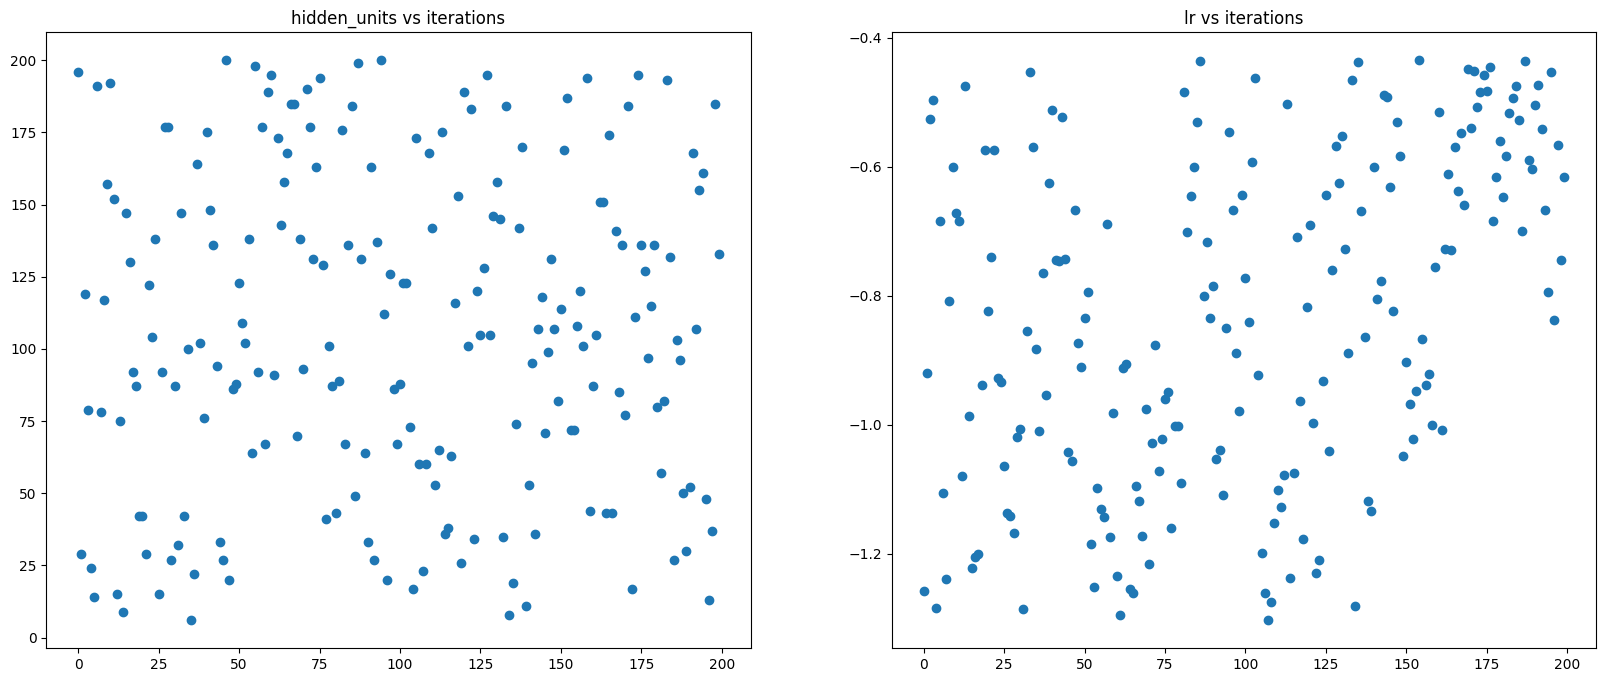

In [15]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
ax = ax.reshape(-1)
# ax[0].scatter(tpe_results['iteration'], tpe_results['activation']+1)
# ax[0].set_title('activation vs iterations')
# ax[1].scatter(tpe_results['iteration'], tpe_results['optimizer'])
# ax[1].set_title('optimizer vs iterations')
ax[0].scatter(tpe_results['iteration'], tpe_results['hidden_units']+1)
ax[0].set_title('hidden_units vs iterations')
ax[1].scatter(tpe_results['iteration'], np.log10(np.array(tpe_results['learning_rate'].values, dtype='float')))
ax[1].set_title('lr vs iterations')

In [16]:
best

{'activation': 'relu',
 'hidden_units': 104,
 'learning_rate': 0.22741165462901555,
 'optimizer': 'adam'}

In [17]:
best_idx = tpe_results.sort_values('loss')['iteration'].values[0]

In [18]:
tpe_trials.results[best_idx]['model'].summary()

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 104)            │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 1)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253 (4.90 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 836 (3.27 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.1735 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8784 - loss: 0.5851
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step


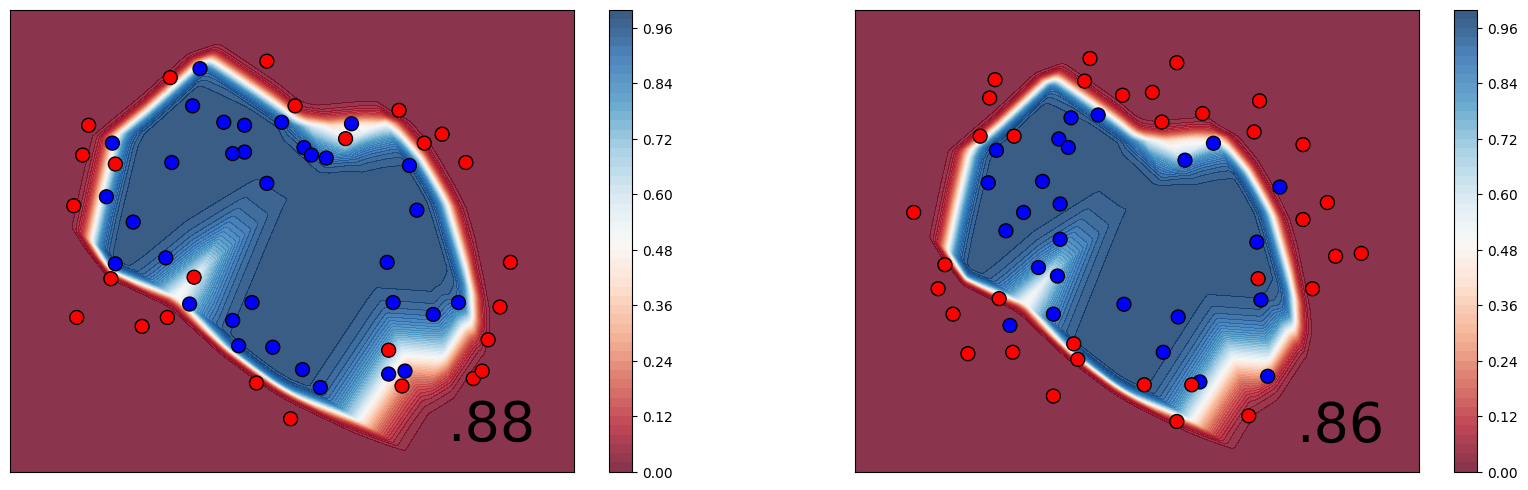

In [19]:
clf = tpe_trials.results[best_idx]['model']

score_train = clf.evaluate(X_train, y_train)[1]
score_test = clf.evaluate(X_val, y_val)[1]
# Graficamos probabilidades en el plano de la combinación de todos los clasificadores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries_keras(X_train, y_train, score_train, clf.predict, ax=ax1)
RHelper.plot_boundaries_keras(X_val, y_val, score_test, clf.predict, ax=ax2)

In [125]:
clf.save('model_88.hdf5')